# 项目：调查巴西预约挂号求诊信息数据集

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
<li><a href="#resources">参考网站</a></li>
</ul>

<a id='intro'></a>
## 简介

> 本数据集源自 [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments) ，包含10万条巴西预约挂号的求诊信息，旨在研究病人是否如约前往医院就诊，原因是每年患者未能如约就诊的行为对公共医疗系统造成了很大的损失。数据集中每行数据录入了有关患者特点的多个数值，包括 “预约日期 (`ScheduledDay`)”指患者具体预约就诊的日期；“街区 (`Neighborhood`) ”指医院所在位置；“福利保障 (`Scholarship`)”说明病人是否是巴西福利项目 [Bolsa Família](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia) 的保障人群；最后一列内容的编码：“`No`”表示病人已如约就诊，“`Yes`”说明病人未前往就诊。

> 此次探究目的在于找到可能决定一个病人是否如约前往就诊的主要因素。

In [1]:
# 首先进行导入数据集探究必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
pd.set_option('max_columns', 30)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a id='wrangling'></a>
## 数据整理

在这一段报告中，我将首先载入数据，检查简洁度，然后整理和清理数据集，以便后面的分析。

### 常规属性

In [2]:
# 导入数据集的数据并打印前几行，以便对数据进行初步了解
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# 检查数据类型，以及是否有缺失数据
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


从以上单元格可以看出，数据集的所有列均不存在缺失数据。

然而某些列的数据类型应当进行转换，比如由于`PatientId`和`AppointmentID`均为数字，`Pandas`将其类型自动识别为`float`和`int`，然而这导致`PatientID`以科学计数法显示，因此最好将其转换为`str`类型。

`ScheduledDay`和`AppointmentDay`均表示日期，因此可以将这两列的数据类型转换为日期格式，以方便计算预约时间和就诊时间的间隔。

In [4]:
# 检查数字类型的数据信息，以查看是否有不合理或错误数据
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


上面的`PatientId`和`AppointmentID`这两列均数据不包含除数字以外的符号，因此不存在问题。

`Hipertension`、`Diabetes`、`Alcoholism`以及`SMS_received`列均用`0`表示`False`，用`1`表示`True`。由于这四列的最小值为0，最大值为1，因此不存在问题。有关`Handcap`的数据，在查阅此数据集的 [Kaggle讨论区](https://www.kaggle.com/joniarroba/noshowappointments/discussion/32174#latest-178364) 后可知此列并非用`0`和`1`布尔值。此列数字代表患者身上残疾处的数量，比如`0`代表患者不存在残疾，`1`代表患者存在一处残疾，`2`代表患者存在两处残疾，以此类推。

表示年龄的`Age`列存在异常数据。其最大值为`115`，可能是由于长寿原因，然而最小值为`-1`，不合常理。因此，在后面的数据清理过程中需要重点留意此列。

### 数据清理

在上面的常规属性部分，我们发现了几处需要转换类型的数据和需要处理的异常数据，总结如下：

数据类型转换：
- 将`PatientId`和`AppointmentID`两列数据转换为`str`类型。
- 将`ScheduledDay`和`AppointmentDay`两列数据转换为`datetime`类型。

异常数据处理：
- 将`Age`列数字为负数的数据行删除。

In [5]:
# 转换PatientID和AppointmentID的数据类型
df['PatientId'] = df['PatientId'].astype(int).astype(str)
df['AppointmentID'] = df['AppointmentID'].astype(int).astype(str)

df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


在对`ScheduledDay`和`AppointmentDay`进行类型转换之前，我们留意到这两列数据的日期形式并不完全一致。`ScheduledDay`精确到了预约时间的秒，然而`AppointmentDay`只精确到了日期的天。

因此，为了保证数据表达的时间形式统一，以方便后续对时间间隔进行计算，我们先只截取`ScheduledDay`的日期部分，舍弃时间部分，然后再进行数据类型的转换。

In [6]:
# 取ScheduledDay的日期部分，储存在列表后将列表转换为Numpy的数列。

datetime_list = []

for date in df['ScheduledDay'].str.split('T'):
    datetime_list.append(date[0])

datetime_array = np.array(datetime_list)

In [7]:
# 转换ScheduledDay和AppointmentDay的数据类型
df['ScheduledDay'] = pd.to_datetime(datetime_array)
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


然后开始处理异常数据。先前我们发现`Age`列有负数的存在，因此对含有负数`Age`数据的列进行查看。

In [8]:
# 查看Age数据为负数的行
df.query('Age < 0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,465943158731293,5775010,F,2016-06-06,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No


由于只有一行数据的`Age`为负数，对总体数据影响不大，因此我们只需要删除那一行数据即可。

In [9]:
df.drop(99832, axis = 0, inplace = True)
df.query('Age < 0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


### 添加额外数据

完成了数据类型的转换和对异常数据的处理后，我们还可以在数据整理的过程中根据原始数据添加额外的列，以方便后续的统计学计算和建立回归模型。

首先，我们可以通过对`ScheduledDay`和`AppointmentDay`进行减法来得到预约和就诊的间隔，把结果储存至DataFrame的`time_interval`列中。

In [10]:
df['Time_interval'] = df['AppointmentDay'] - df['ScheduledDay']
df['Time_interval'][:10]

0   0 days
1   0 days
2   0 days
3   0 days
4   0 days
5   2 days
6   2 days
7   2 days
8   0 days
9   2 days
Name: Time_interval, dtype: timedelta64[ns]

这里还可以继续对`time_interval`进行类型转换，因为`datetime`类型的数据并不是非常方便进行数学计算，例如计算平均值等，因此此处我们再将`time_interval`转为`int`类型。

In [11]:
# 用一个列表收集所有时间间隔的天数
int_interval_list = []

for date in df['Time_interval'].astype(str).str.split():
    int_interval_list.append(int(date[0]))
    
# 将列表转换为Numpy的array后储存至df
int_interval_array = np.array(int_interval_list)
df['Time_interval'] = int_interval_array

但这个时候，由于添加了额外数据，我们还需要额外检查时间间隔这一变量里的所有数据是否都符合常理，比如`AppointmentDay`应当是在`ScheduledDay`之后的，所以`Time_interval`里的所有数字应当都大于或等于零。

In [12]:
sum(df['Time_interval'] < 0)

5

上面的计算结果说明有五条预约就诊信息的`Time_interval`变量为负数，我们具体来看是哪些行出现了异常数据。

In [13]:
df.query('Time_interval < 0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_interval
27033,7839272661752,5679978,M,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,-1
55226,7896293967868,5715660,F,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,-1
64175,24252258389979,5664962,F,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,-1
71533,998231581612122,5686628,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,-6
72362,3787481966821,5655637,M,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,-1


上面列出的预约就诊信息的时间间隔为`-1`或`-6`，属于异常数据，但由于数量不大，因此可以直接将这五行数据删除。

In [14]:
df.drop(27033, axis = 0, inplace = True)
df.drop(55226, axis = 0, inplace = True)
df.drop(64175, axis = 0, inplace = True)
df.drop(71533, axis = 0, inplace = True)
df.drop(72362, axis = 0, inplace = True)

In [15]:
df.query('Time_interval < 0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_interval


对于`Age`一列，虽然对数字可以很方便地建立回归模型，但是额外对`Age`进行年龄段分组可以更加便捷地进行统计学分析和可视化。

对年龄数据的分组标准为：
- 0岁以上至15岁：儿童
- 15岁以上至30岁：青年
- 30岁以上至60岁：中年
- 60岁以上至120岁：老年

In [16]:
bins = [-1, 15, 30, 60, 120]
df['Age_group'] = pd.cut(df['Age'], bins, labels = ['children', 'young', 'middle-aged', 'old'])

In [17]:
df['Age_group'][:10]

0            old
1    middle-aged
2            old
3       children
4    middle-aged
5            old
6          young
7    middle-aged
8          young
9          young
Name: Age_group, dtype: category
Categories (4, object): [children < young < middle-aged < old]

然后我们为分类数据建立虚拟变量，这样可以不仅对数值数据建立逻辑回归模型，还可以对分类变量建立模型。

首先查看各个分类变量具体包含了多少种分类。

In [18]:
def print_categorical(categorical):
    """
    函数打印某一分类变量的分类种类的数量。
    """
    print('{}: {}'.format(categorical, df[categorical].nunique()))

In [19]:
print_categorical('Gender')
print_categorical('Handcap')
print_categorical('Neighbourhood')
print_categorical('No-show')
print_categorical('Age_group')

Gender: 2
Handcap: 5
Neighbourhood: 81
No-show: 2
Age_group: 4


各个分类变量的分类种类的数量显示，对于`Gender`、`Handcap`、`Age_group`以及`No-show`，由于其包含的类型不多，我们可以很容易地创建虚拟变量。但是`Neighbourhood`包含了太多种类，不方便创建虚拟变量，也很难对其进行描述统计学探究。在后面的探索性数据分析过程中，我们会忽略这一分类变量。

下面对`Gender`、`Handcap`、`Age_group`以及`No-show`创建虚拟变量，并删除信息重复或多余的列。

In [20]:
df[['Female', 'Male']] = pd.get_dummies(df['Gender'])
df.drop('Female', axis = 1, inplace = True)

In [21]:
df[['No_handcap', 'Handcap1', 'Handcap2', 'Handcap3', 'Handcap4']] = pd.get_dummies(df['Handcap'])

In [22]:
df[['Children', 'Young', 'Middle-aged', 'Old']] = pd.get_dummies(df['Age_group'])

In [23]:
df['No-show'] = pd.get_dummies(df['No-show'])['Yes']

In [24]:
df.drop('ScheduledDay', axis = 1, inplace = True)
df.drop('AppointmentDay', axis = 1, inplace = True)

现在我们完成了所以数据整理过程，可以直接利用下面的DataFrame开始统计学分析和建立逻辑回归模型。

In [25]:
df.head()

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_interval,Age_group,Male,No_handcap,Handcap1,Handcap2,Handcap3,Handcap4,Children,Young,Middle-aged,Old
0,29872499824296,5642903,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,old,0,1,0,0,0,0,0,0,0,1
1,558997776694438,5642503,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0,middle-aged,1,1,0,0,0,0,0,0,1,0
2,4262962299951,5642549,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,old,0,1,0,0,0,0,0,0,0,1
3,867951213174,5642828,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0,children,0,1,0,0,0,0,1,0,0,0
4,8841186448183,5642494,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0,middle-aged,0,1,0,0,0,0,0,0,1,0


<a id='eda'></a>
## 探索性数据分析

> 在整理和清理数据之后，现在可以进行探索。探索的过程包括计算统计值，创建可视化图，以及建立逻辑回归模型，以解决在简介段提出的研究问题，**哪些是决定一个病人是否如约前往就诊的主要因素？**

#### 探究因素目录
<ul>
<li><a href="#gender">性别</a></li>
<li><a href="#age">年龄段</a></li>
<li><a href="#scholarship">福利保障</a></li>
<li><a href="#hypertension">高血压、糖尿病和酗酒</a></li>
<li><a href="#handcap">残疾</a></li>
<li><a href="#SMS">短信提示</a></li>
<li><a href="#interval">预约和就诊间隔天数</a></li>
</ul>

首先，计算出所有预约就诊信息的总条数，然后再分别计算出患者如约就诊和未如约就诊的次数和所占比率。

In [26]:
# 所有预约就诊信息的总条数
total = df.shape[0]
total

110521

In [27]:
# 计算如约就诊和未如约就诊的次数
show_yes_num = df.groupby('No-show')['AppointmentID'].count()[0]
show_no_num = df.groupby('No-show')['AppointmentID'].count()[1]

print("Total number of show-up appointments: {}".format(show_yes_num))
print("Total number of no-show appointments: {}".format(show_no_num))

Total number of show-up appointments: 88207
Total number of no-show appointments: 22314


In [28]:
# 计算如约就诊和未如约就诊的比率
show_yes_prop = show_yes_num / total
show_no_prop = show_no_num / total

print("Show-up appointment proportion: {:.3f}".format(show_yes_prop))
print("No-show appointment proportion: {:.3f}".format(show_no_prop))

Show-up appointment proportion: 0.798
No-show appointment proportion: 0.202


因此，当我们不对预约就诊信息进行任何分组时，如约就诊的次数大约占所有就诊次数的`79.8%`，未如约就诊的次数大约占所有就诊次数的`20.2%`。

<a id='gender'></a>
### 性别对是否如约就诊的影响

在探究性别对是否如约就诊的影响前，我们首先需要计算出此就诊数据中男性和女性的总就诊次数。通过运算结果可以看到女性占了预约就诊信息的近1/3。

In [29]:
male_total = df.groupby('Gender')['AppointmentID'].count()['M']
female_total = df.groupby('Gender')['AppointmentID'].count()['F']

print('Male total count: {}'.format(male_total))
print('Female total count: {}'.format(female_total))

Male total count: 38685
Female total count: 71836


然后，可以利用`Pandas`的`crosstab`函数来得到男性和女性如约就诊和未如约就诊的次数。

In [30]:
gender_crosstab = pd.crosstab(df['Gender'], df['No-show'])
gender_crosstab

No-show,0,1
Gender,,
F,57245,14591
M,30962,7723


下面的横向堆积条形图展示了女性和男性的总就诊数量、如约就诊数量（蓝色部分）和未如约就诊数量（粉色部分）。

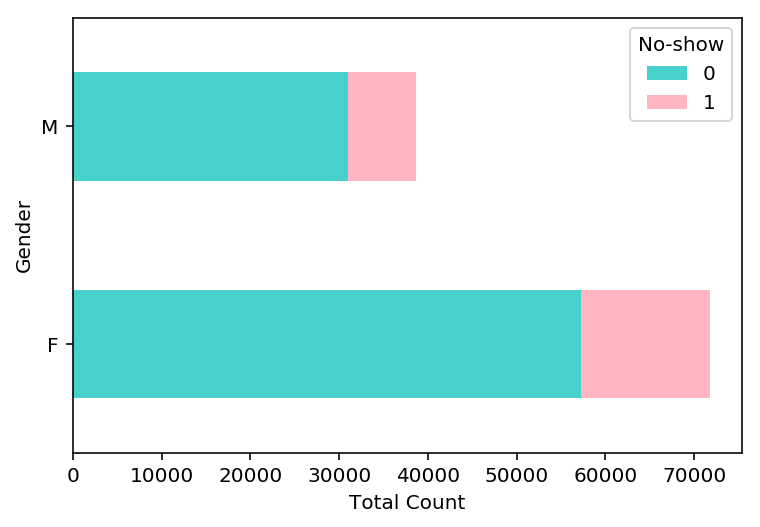

In [31]:
gender_crosstab.plot(kind = 'barh', stacked = True, color = ['mediumturquoise', 'lightpink'])
plt.xlabel('Total Count');

接下来分别计算男性和女性未如约就诊次数占其性别所有就诊次数的百分比。

In [32]:
male_no_show_prop = gender_crosstab[1]['M'] / male_total
female_no_show_prop = gender_crosstab[1]['F'] / female_total

print('Proportion of no-show appointment of male: {:.3f}'.format(male_no_show_prop))
print('Proportion of no-show appointment of female: {:.3f}'.format(female_no_show_prop))

Proportion of no-show appointment of male: 0.200
Proportion of no-show appointment of female: 0.203


当然，由于`No-show`信息在DataFrame中是通过数字`0`和`1`来表示（其中`1`代表未如约就诊，`0`代表如约就诊），我们也可以直接通过`mean`函数得到相同的结果。

In [33]:
df.groupby('Gender')['No-show'].mean()

Gender
F    0.203115
M    0.199638
Name: No-show, dtype: float64

In [34]:
gender_diff = female_no_show_prop - male_no_show_prop
gender_diff

0.0034773269658648354

可以看到，男性和女性的未如约就诊的比率相差非常小，只有0.3%左右。下面的饼图也展示了这一差别非常微小。

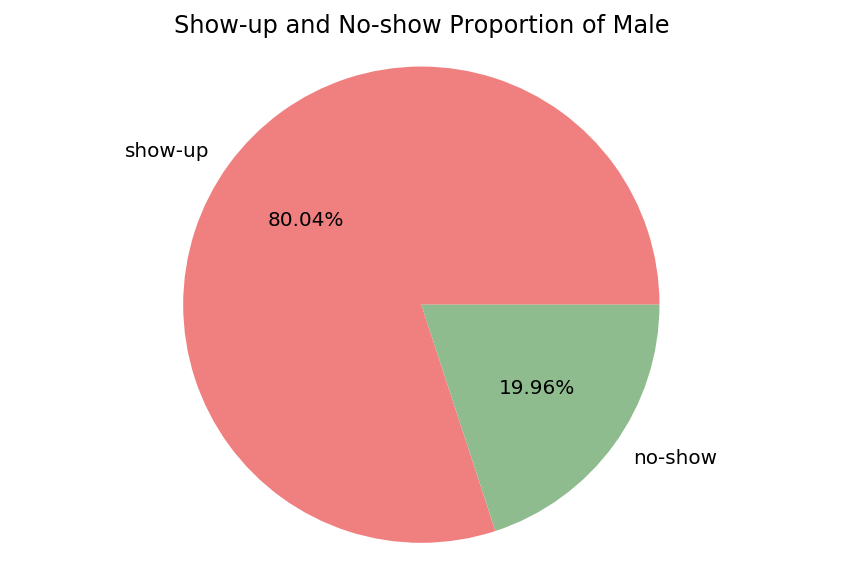

In [35]:
plt.pie([gender_crosstab[0]['M'], gender_crosstab[1]['M']], labels = ['show-up', 'no-show'],
        colors = [ 'lightcoral', 'darkseagreen'], autopct = '%.2f%%')
plt.axis('equal')
plt.tight_layout()
plt.title('Show-up and No-show Proportion of Male');

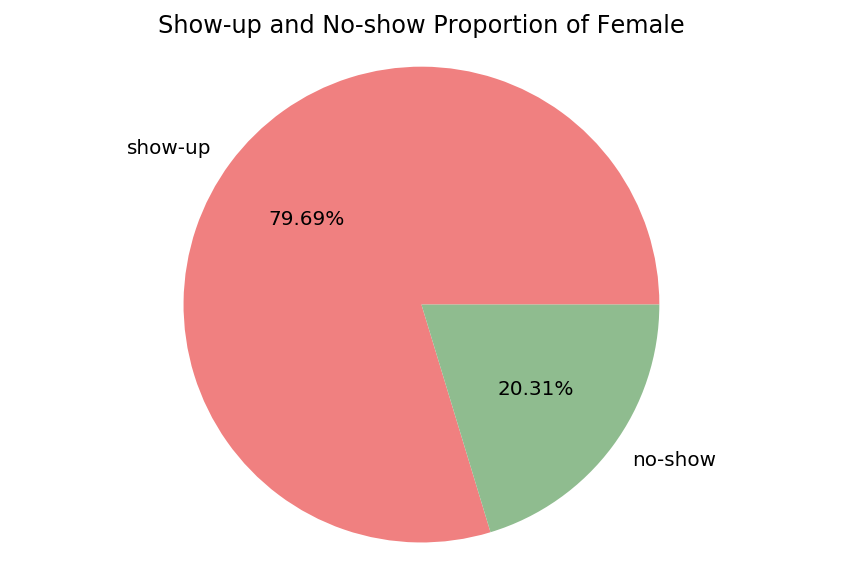

In [36]:
plt.pie([gender_crosstab[0]['F'], gender_crosstab[1]['F']], labels = ['show-up', 'no-show'],
        colors = [ 'lightcoral', 'darkseagreen'], autopct = '%.2f%%')
plt.axis('equal')
plt.tight_layout()
plt.title('Show-up and No-show Proportion of Female');

由于男性和女性的未如约就诊的比率相差非常微小，这暗示了性别对于是否如约就诊的影响可能并不大。为了验证这一猜测，我们可以将患者性别视作自变量，将是否如约就诊作为因变量，拟合逻辑回归，然后通过p值来判断性别的影响。

In [37]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
sm.Logit(df['No-show'], sm.add_constant(df['Male'])).fit().summary()

Optimization terminated successfully.
         Current function value: 280.060810
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                No-show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110519
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:              -3.859e-05
Time:                        09:27:31   Log-Likelihood:            -3.0953e+07
converged:                       True   LL-Null:                   -3.0951e+07
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3669      0.009   -147.397      0.000      -1.385      -1.349
Male          -0.0216      0.016     -1.374      0.170      -0.052       0.009
==============================================================================
"""

以上`Male`的系数为`-0.0216`，p-value为`0.170`，属于非常大的p值。由于p值代表当零假设为真时所得到的样本观察结果或更极端结果出现的概率，而此处的零假设为男性和女性患者未能如约就诊概率相等，因此我们可以得出结论，性别这一因素在此次探究中对因变量不存在影响。

<a id='age'></a>
### 年龄段对是否如约就诊的影响

首先利用`Pandas`的`value_counts`函数查看各个年龄段的患者数量。可以看出，中年患者的数量最多，儿童和青年患者的数量占其次，60岁以上的老年患者的数量最少。

In [38]:
df['Age_group'].value_counts()

middle-aged    45132
children       24467
young          21161
old            19761
Name: Age_group, dtype: int64

然后利用`Pandas`的`groupby`函数来计算各个年龄段患者未如约就诊的比率。

In [39]:
age_group_prop = df.groupby('Age_group')['No-show'].mean()
age_group_prop

Age_group
children       0.214452
young          0.247625
middle-aged    0.195471
old            0.152067
Name: No-show, dtype: float64

下面将各个年龄段为如约就诊的比率绘制成了条形统计图，可以看出比率并不随着患者年龄的增长而增长或者降低，而是区别于各个年龄段。其中，青年患者未能如约就诊的比率最大，大约有1/4的去青年患者未如约就诊。老年患者未能如约就诊的比率最小，只有大约15%左右。

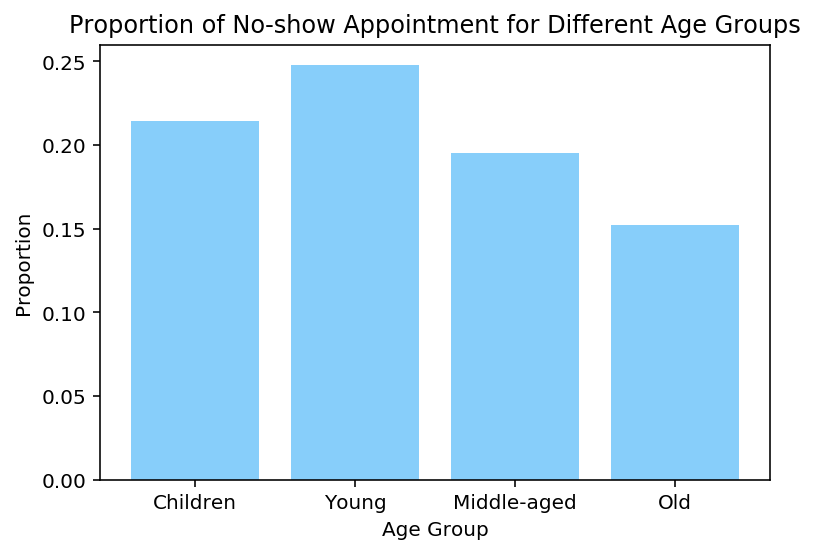

In [40]:
plt.bar(range(4), [age_group_prop['children'], age_group_prop['young'], age_group_prop['middle-aged'], 
                   age_group_prop['old']], color = 'lightskyblue', tick_label = ['Children', 'Young', 
                                                                                 'Middle-aged', 'Old'])
plt.title('Proportion of No-show Appointment for Different Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Proportion')
plt.show()

接下来对年龄数据建立逻辑回归模型。其中有两种方法可以采用，第一种是将年龄视为数值变量，因此将`Age`作为自变量传入回归模型，第二种是将年龄段视为分类变量，因此将根据年龄段创造的虚拟变量传入回归模型。在这里我们会将这两种方式都尝试一下。

先尝试把`Age`视作自变量，因此`No-show`为因变量，建立逻辑回归模型。

In [41]:
sm.Logit(df['No-show'], sm.add_constant(df['Age'])).fit().summary()

Optimization terminated successfully.
         Current function value: 282.377270
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                No-show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110519
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:               -0.008310
Time:                        09:27:32   Log-Likelihood:            -3.1209e+07
converged:                       True   LL-Null:                   -3.0951e+07
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1379      0.014    -82.961      0.000      -1.165      -1.111
Age           -0.0066      0.000    -20.015      0.000      -0.007      -0.006
==============================================================================
"""

In [42]:
np.exp(-0.0066)

0.99342173216295715

`Age`变量的p值为`0.000`，说明年龄这一自变量在很大的概率上对因变量（是否如约就诊）有影响。系数为`-0.0066`，负数说明患者的年龄每增加一岁，未能如约就诊的概率就变成原概率的约`0.9934`倍，即年龄越大的患者未能如约就诊的可能性越小，符合我们前面通过数据可视化得到的结论（老年患者未能如约就诊的比率最小）。

然而在前面的可视化部分中，我们还发现未如约就诊比率事实上并不随着患者年龄的增长而连续增长或者连续降低，因此我们可以将患者所属的不同年龄段视为分类变量，把根据年龄段创造的虚拟变量传入回归模型。下面回归模型的基准值为`Children`。

In [43]:
sm.Logit(df['No-show'], sm.add_constant(df[['Young', 'Middle-aged', 'Old']])).fit().summary()

Optimization terminated successfully.
         Current function value: 283.684666
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                No-show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110517
Method:                           MLE   Df Model:                            3
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:                -0.01298
Time:                        09:27:32   Log-Likelihood:            -3.1353e+07
converged:                       True   LL-Null:                   -3.0951e+07
                                        LLR p-value:                     1.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.2983      0.016    -83.352      0.000      -1.329      -1.268
Young           0.1870      0.022      8.393      0.000       0.143       0.231
Middle-aged    -0.1165      0.020     -5.951      0.000      -0.155      -0.078
Old            -0.4202      0.025    -16.674      0.000      -0.470      -0.371
===============================================================================
"""

In [44]:
# Young
np.exp(0.1870)

1.2056272850499248

In [45]:
# Middle-aged
np.exp(-0.1165)

0.89003009697667756

In [46]:
# Old
np.exp(-0.4202)

0.65691542359115418

上面通过年龄段这一分类变量得到的逻辑回归模型相比先前通过年龄这一数值变量得到的模型所展示的患者年龄与是否如约就诊之间的联系更为清晰。所有变量的p值均为`0.000`，说明患者所处年龄段这一自变量在很大的概率上对因变量（是否如约就诊）有影响。

基准值为`Children`这一年龄段，因此`Young`的系数`0.1870`说明了青年患者未能如约就诊的概率为儿童患者的`1.2056`倍，`Middle-aged`的系数`-0.1165`说明了中年患者未能如约就诊的概率为儿童患者的`0.8900`倍，`Old`的系数`-0.4202`说明了老年患者未能如约就诊的概率为儿童患者的`0.6570`倍。

以上通过逻辑回归模型得出的结论均符合先前通过数据可视化得到的结论，即青年患者未能如约就诊的比率最大，老年患者未能如约就诊的比率最小。

然而，即使这里得到的结论非常符合原始数据，我们也不能100%确认年龄会影响患者是否如约就诊的概率，因为回归模型的前提假设是“当其它因素不变”，然而患者所处年龄段从“儿童”变成“老年”时，其它因素也会发生相应变化，比如患严重疾病的概率，等等。

<a id='scholarship'></a>
### 福利保障对是否如约就诊的影响

首先，利用`Pandas`的`crosstab`函数分别得出有福利保障和无福利保障患者的如约就诊数量以及未如约就诊数量，并根据结果绘制条形统计图，以便更加直观地对各个分类患者的数量有所了解。

In [47]:
scholarship_crosstab = pd.crosstab(df['Scholarship'], df['No-show'])
scholarship_crosstab

No-show,0,1
Scholarship,,
0,79924,19736
1,8283,2578


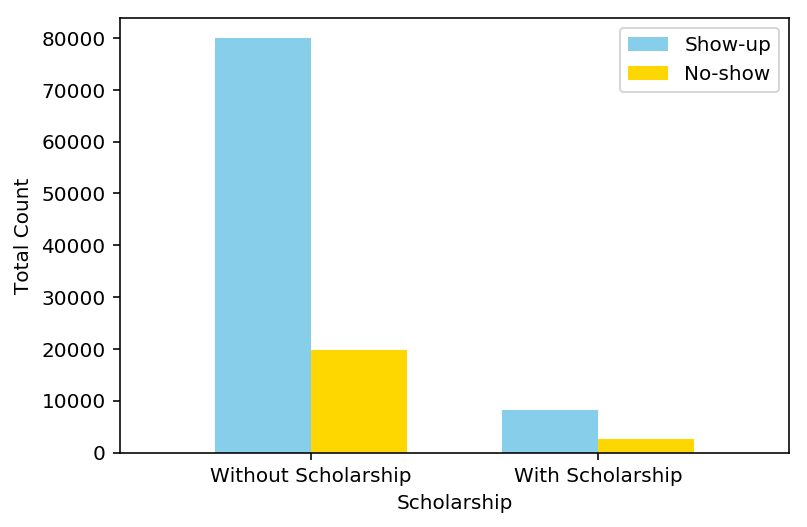

In [48]:
plt.bar([1.5, 4.5], [scholarship_crosstab[0][0], scholarship_crosstab[0][1]], 1, label = 'Show-up', color = 'skyblue')
plt.bar([2.5, 5.5], [scholarship_crosstab[1][0], scholarship_crosstab[1][1]], 1, label = 'No-show', color = 'gold')
plt.xlim(0, 7)
plt.xticks([2, 5], ['Without Scholarship', 'With Scholarship'])
plt.legend(loc = 'best')
plt.xlabel('Scholarship')
plt.ylabel('Total Count')
plt.show()

通过上图可以看出，无福利保障的患者占了大多数，因此无论是从如约就诊还是未如约就诊的数量来看，无福利保障患者都比有福利保障患者更多。然而，我们很难从图中看出通过福利保障区分的两组患者哪一组未如约就诊的比率更高。

因此，利用`Pandas`的`query`函数对有福利保障和无福利保障的患者分别建立DataFrame，然后计算出每组患者的平均未就诊率。

In [49]:
with_scholarship_df = df.query('Scholarship == 1')
without_scholarship_df = df.query('Scholarship == 0')

In [50]:
with_scholarship_no_show_prop = with_scholarship_df['No-show'].mean()
without_scholarship_no_show_prop = without_scholarship_df['No-show'].mean()

print('No-show proportion of patients with scholarship: {:.2f}'.format(with_scholarship_no_show_prop))
print('No-show proportion of patients without scholarship: {:.2f}'.format(without_scholarship_no_show_prop))

No-show proportion of patients with scholarship: 0.24
No-show proportion of patients without scholarship: 0.20


可以看出，有福利保障的患者未如约就诊的比率要高于无福利保障的患者。通过下面计算，我们得知在此数据集中，福利保障患者和无福利保障患者的未就诊率的差大约为`3.93%`。

In [51]:
scholarship_diff = with_scholarship_no_show_prop - without_scholarship_no_show_prop
scholarship_diff * 100

3.9329728812055458

为了得知这`3.93%`的差别是否具有统计显著性，这里我们可以用拔靴法抽样分布或逻辑回归进行假设检验。

我们的零假设和对立假设如下：

零假设：有福利保障的患者未能如约就诊的比率等于无福利保障的患者未能如约就诊的比率

$$
H_{null}: p_{with\_scholarship} = p_{without\_scholarship}
$$

对立假设：有福利保障的患者未能如约就诊的比率不等于无福利保障的患者未能如约就诊的比率

$$
H_{alternative}: p_{with\_scholarship} \neq p_{without\_scholarship}
$$

然而，由于此数据集的样本容量较大，拔靴法抽样分布的程序运行时间过长，我们在这里只利用逻辑回归模型得到假设检验的结果。

In [52]:
sm.Logit(df['No-show'], sm.add_constant(df['Scholarship'])).fit().summary()

Optimization terminated successfully.
         Current function value: 280.543521
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                No-show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110519
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:               -0.001762
Time:                        09:27:33   Log-Likelihood:            -3.1006e+07
converged:                       True   LL-Null:                   -3.0951e+07
                                        LLR p-value:                     1.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3986      0.008   -175.959      0.000      -1.414      -1.383
Scholarship     0.2314      0.024      9.679      0.000       0.185       0.278
===============================================================================
"""

In [53]:
np.exp(0.2314)

1.2603632839471901

可以看到，`Scholarship`这一自变量的p值为`0.000`，说明对立假设在很大的概率上为真，我们应当拒绝零假设。系数为`0.2314`，说明其它因素不变时，有福利保障的患者未能如约就诊的概率是无福利保障患者的约`1.26`倍。

<a id='hypertension'></a>
### 高血压、糖尿病和酗酒对是否如约就诊的影响

首先，我们需要计算出有/无高血压、糖尿病和酗酒习惯的各组患者未如约就诊的比率。

我们可以定义两个函数`calculate_no_show_prop`和`print_prop`，可以反复使用，使代码更加简洁。

In [54]:
def calculate_no_show_prop(factor):
    """
    函数计算传入factor的各组（即有factor的患者组和无factor的患者组）的未如约就诊的比率。
    """

    df0 = df.query('{} == 0'.format(factor))
    df1 = df.query('{} == 1'.format(factor))
    
    df0_prop = df0['No-show'].mean()
    df1_prop = df1['No-show'].mean()
    
    return (df0_prop, df1_prop)

In [55]:
def print_prop(factor):
    print('Without {}: {:.2f} With {}: {:.2f}'.format(factor, calculate_no_show_prop(factor)[0], 
                                                      factor, calculate_no_show_prop(factor)[1]))

In [56]:
print_prop('Hipertension')
print_prop('Diabetes')
print_prop('Alcoholism')

Without Hipertension: 0.21 With Hipertension: 0.17
Without Diabetes: 0.20 With Diabetes: 0.18
Without Alcoholism: 0.20 With Alcoholism: 0.20


从计算结果可以看出，此数据集中有高血压或糖尿病的患者未能如约就诊的比率比无高血压和糖尿病的患者要低，但是是否酗酒这一点对患者是否如约就诊似乎没有什么影响。

为了验证上面得到的计算结果，我们可以再次使用逻辑回归。这次，我们可以把`Hipertention`、`Diabetes`以及`Alcoholism`全部当作自变量放入回归模型中。

In [57]:
sm.Logit(df['No-show'], sm.add_constant(df[['Hipertension', 'Diabetes', 'Alcoholism']])).fit().summary()

Optimization terminated successfully.
         Current function value: 280.915420
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                No-show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110517
Method:                           MLE   Df Model:                            3
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:               -0.003090
Time:                        09:27:33   Log-Likelihood:            -3.1047e+07
converged:                       True   LL-Null:                   -3.0951e+07
                                        LLR p-value:                     1.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.3321      0.008   -159.704      0.000      -1.348      -1.316
Hipertension    -0.2363      0.022    -10.770      0.000      -0.279      -0.193
Diabetes         0.0043      0.034      0.129      0.897      -0.061       0.070
Alcoholism       0.0440      0.044      1.003      0.316      -0.042       0.130
================================================================================
"""

In [58]:
np.exp(-0.2363)

0.78954377526719943

In [59]:
np.exp(0.0043)

1.0043092582654238

在逻辑回归模型中，`Hipertension`的p值为`0.000`，说明患者是否患有高血压对其未如约就诊的比率确实存在影响。系数为`-0.2363`，说明患有高血压的患者未如约就诊的概率是未患有高血压的患者的`0.7895`倍。

变量`Alcoholism`的p值非常大，且置信区间经过`0`，符合我们先前的观察预计，即患者是否酗酒对其未如约就诊的概率没有影响。

然而变量`Diabetes`在回归模型中的相关数据并不完全符合我们的预期，因为统计结果显示有糖尿病的患者未能如约就诊的比率比无糖尿病的患者要低，但是此处`Diabetes`的系数为`0.0043`，说明有糖尿病的患者未能如约就诊的概率是未患有高血压的患者的`1.0043`倍。

另外我们注意到，`Diabetes`的p值非常大且置信区间也包含了负的系数，因此可以合理怀疑有一个现象可能导致了这一结果，即[多重共线性](https://en.wikipedia.org/wiki/Multicollinearity)。

通过资料查阅，我们发现糖尿病和高血压存在一定的关联，比如[这篇文章](https://www.medicalnewstoday.com/articles/317220.php)指出，至少有1/3的I型糖尿病患者患有高血压。

验证多重共线性最简单的方式就是对各个自变量建立独立的回归模型，因此下面我们将分别计算并得出`Hipertension`和`Diabetes`的逻辑回归系数。

In [60]:
sm.Logit(df['No-show'], sm.add_constant(df['Hipertension'])).fit().summary()

Optimization terminated successfully.
         Current function value: 280.909508
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                No-show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110519
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:               -0.003069
Time:                        09:27:34   Log-Likelihood:            -3.1046e+07
converged:                       True   LL-Null:                   -3.0951e+07
                                        LLR p-value:                     1.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.3310      0.008   -161.193      0.000      -1.347      -1.315
Hipertension    -0.2334      0.020    -11.836      0.000      -0.272      -0.195
================================================================================
"""

In [61]:
np.exp(-0.2334)

0.79183677545874132

In [62]:
sm.Logit(df['No-show'], sm.add_constant(df['Diabetes'])).fit().summary()

Optimization terminated successfully.
         Current function value: 280.204176
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                No-show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110519
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:              -0.0005505
Time:                        09:27:34   Log-Likelihood:            -3.0968e+07
converged:                       True   LL-Null:                   -3.0951e+07
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3640      0.008   -175.909      0.000      -1.379      -1.349
Diabetes      -0.1521      0.030     -5.035      0.000      -0.211      -0.093
==============================================================================
"""

In [63]:
np.exp(-0.1521)

0.85890238620784765

`Hipertension`和`Diabetes`在其各自的逻辑回归模型的p值均为`0.000`，说明这两个自变量对未能如约就诊的概率均是有影响的。

而且，现在`Diabetes`的系数为负数，符合我们的预期，其说明了患有糖尿病的患者未如约就诊的概率是未患有糖尿病的患者的`0.8589`倍。`Hipertension`的系数和前面得到的回归模型中的系数相差不大，说明了患有高血压的患者未如约就诊的概率是未患有高血压的患者的`0.7918`倍。

因此总结这一部分得到的结论，酗酒对未如约就诊的概率没有影响，糖尿病和高血压均会提升患者如约就诊的概率。

<a id='handcap'></a>
### 残疾对是否如约就诊的影响

在研究残疾对患者是否如约就诊的影响之前，需要首先明确先前提到过的，在此数据集中`Handcap`不用`0`和`1`来表示患者是否有残疾，而是用数字表示患者身上残疾的数量。

在先前为`Handcap`变量创建虚拟变量时，我们已经得知`Handcap`最小为`0`，最大为`4`，说明此数据集中患者身上最多可能存在四处残疾。

可以创建一个和先前`calculate_no_show_prop`相似的函数，来计算并打印有不同残疾数量的患者未如约就诊的比率。

In [64]:
def cal_print_handcap_no_show_prop(num_handcap):
    """
    函数计算并打印拥有num_handcap处残疾的患者未能如约就诊的比率。
    """

    df_handcap = df.query('Handcap == {}'.format(num_handcap))
    
    no_show_prop = df_handcap['No-show'].mean()
    
    print('No-show probability of patients with {} desabilites: {:.2f}'.format(num_handcap, no_show_prop))
    
    return no_show_prop

In [65]:
hand0_prop = cal_print_handcap_no_show_prop(0)
hand1_prop = cal_print_handcap_no_show_prop(1)
hand2_prop = cal_print_handcap_no_show_prop(2)
hand3_prop = cal_print_handcap_no_show_prop(3)
hand4_prop = cal_print_handcap_no_show_prop(4)

No-show probability of patients with 0 desabilites: 0.20
No-show probability of patients with 1 desabilites: 0.18
No-show probability of patients with 2 desabilites: 0.20
No-show probability of patients with 3 desabilites: 0.23
No-show probability of patients with 4 desabilites: 0.33


我们可以把这一计算结果绘制成条形统计图，如下所示。

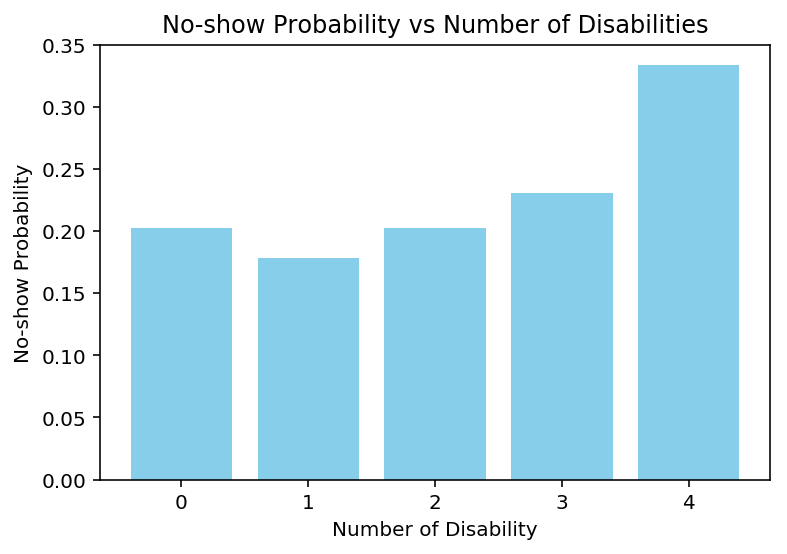

In [66]:
plt.bar(range(5), [hand0_prop, hand1_prop, hand2_prop, hand3_prop, hand4_prop], color = 'skyblue')
plt.title('No-show Probability vs Number of Disabilities')
plt.xlabel('Number of Disability')
plt.ylabel('No-show Probability');

如果忽略健全患者而只关注身上有残疾的患者，可以看到趋势大致符合患者身上的残疾越多，患者未能如约就诊的比率也就越大。

接下来，利用逻辑回归模型来验证这一猜想。这里可以传入两种形式的自变量，一是将患者身上的残疾数看作数值变量，直接传入`Handcap`，二是将不同残疾数这一属性看作分类变量，传入根据`Handcap`创建的虚拟变量。

In [67]:
sm.Logit(df['No-show'], sm.add_constant(df['Handcap'])).fit().summary()

Optimization terminated successfully.
         Current function value: 280.076594
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                No-show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110519
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:              -9.495e-05
Time:                        09:27:34   Log-Likelihood:            -3.0954e+07
converged:                       True   LL-Null:                   -3.0951e+07
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3723      0.008   -181.521      0.000      -1.387      -1.357
Handcap       -0.1011      0.048     -2.090      0.037      -0.196      -0.006
==============================================================================
"""

In [68]:
np.exp(-0.1011)

0.90384264410209003

上面是将患者身上的残疾数看作数值变量得到的逻辑回归模型。`Handcap`的p值小于α水平0.05，说明这一变量比较有可能影响患者是否如约就诊的概率。

然而这里得到的`Handcap`系数为负数，说明身上残疾越多的患者，未能如约就诊的概率反而更低，更具体地说，运算结果说明患者身上每多一处残疾，未能如约就诊的概率为原概率的`0.9038`倍，不符合我们先前通过统计学计算和数据可视化得到的结论。

然后尝试将不同残疾数这一属性看作分类变量，传入根据`Handcap`创建的虚拟变量作为自变量以得到逻辑回归模型，结果如下。

In [69]:
sm.Logit(df['No-show'], sm.add_constant(df[['Handcap1', 'Handcap2', 'Handcap3', 'Handcap4']])).fit().summary()

Optimization terminated successfully.
         Current function value: 280.095202
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                No-show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110516
Method:                           MLE   Df Model:                            4
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:              -0.0001614
Time:                        09:27:35   Log-Likelihood:            -3.0956e+07
converged:                       True   LL-Null:                   -3.0951e+07
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3718      0.008   -181.345      0.000      -1.387      -1.357
Handcap1      -0.1552      0.058     -2.662      0.008      -0.270      -0.041
Handcap2      -0.0009      0.184     -0.005      0.996      -0.362       0.360
Handcap3       0.1678      0.658      0.255      0.799      -1.122       1.458
Handcap4       0.6786      1.225      0.554      0.580      -1.722       3.079
==============================================================================
"""

除了`Handcap1`的p值小于0.05以外，`Handcap2`、`Handcap3`和`Handcap4`的p值都非常大，远远超过0.05。这说明对于身上有两处及以上残疾的患者，我们无法仅通过这一特征来判断其未能如约就诊的概率。

在这里，我们猜测的原因是身上有两处及以上残疾的患者的数量非常少，因此很难得到具有统计显著性的结果。

下面计算身上有两处及以上残疾的患者数量。

In [70]:
with_two_more_handcap = 0

for handcap_num in df['Handcap']:
    if handcap_num >= 2:
        with_two_more_handcap += 1

print(with_two_more_handcap)
print(with_two_more_handcap / total)

199
0.0018005627889722314


计算结果说明，在此数据集中，所有身上有两处及以上残疾的患者只有`199`位，仅为总体患者数量的`0.0018`左右，占比非常小。

因此，我们无法证明患者身上的残疾数量对未如约就诊的概率存在影响。

<a id='SMS'></a>
### 短信对是否如约就诊的影响

首先，还是通过先前定义的`print_prop`函数来分别得到没有收到短信提示和有收到短信提示的患者未如约就诊的比率。

In [71]:
print_prop('SMS_received')

Without SMS_received: 0.17 With SMS_received: 0.28


出乎意料的是，收到短信提示的患者未能如约就诊的比率远远高于没有收到短信提示的患者。

接下来，用逻辑回归模型来验证这一统计学计算结果。

In [72]:
sm.Logit(df['No-show'], sm.add_constant(df['SMS_received'])).fit().summary()

Optimization terminated successfully.
         Current function value: 289.367805
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                No-show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110519
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:                -0.03327
Time:                        09:27:35   Log-Likelihood:            -3.1981e+07
converged:                       True   LL-Null:                   -3.0951e+07
                                        LLR p-value:                     1.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.6072      0.010   -164.198      0.000      -1.626      -1.588
SMS_received     0.6415      0.015     41.678      0.000       0.611       0.672
================================================================================
"""

In [73]:
np.exp(0.6415)

1.8993277352320685

`SMS_received`这一自变量的p值为`0.000`，说明患者是否收到了短信提示对其是否如约就诊的概率存在影响。

然而，这一影响的方向和我们预期的不同。正常来说收到短信的患者更有可能会因为提示而如约就诊，可上面的计算结果却说明，收到短信的患者未如约就诊的概率是未收到短信的患者的近两倍（`1.899`倍）。

由于缺乏对这一数据集的进一步解释信息，例如，哪一部分患者会收到提示短信，我们无法判断和短信提示关联的影响因素究竟是什么。

因此，在这一部分，我们无法得到短息提示对患者如约就诊概率的影响的结论。

<a id='interval'></a>
### 预约和就诊间隔天数对是否如约就诊的影响

在探究预约和就诊间隔天数对是否如约就诊的影响之前，我们需要先了解一下`Time_interval`这一变量的描述统计学相关信息。

In [74]:
df['Time_interval'].describe()

count    110521.000000
mean         10.184345
std          15.255153
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: Time_interval, dtype: float64

`Tine_interval`的最小值为`0`，最大值为`179`，平均值约为`10.18`，我们设定的时间间隔的单位为“天”。由于我们已经在数据整理过程中把不合理数据删除了，以上得到的统计学数据均符合常理。

接下来为数据集的`Time_interval`变量绘制直方图。下面的直方图说明了大部分人预约和就诊的时间间隔小于30天，只有很小部分人会提前几个月到半年进行预约。

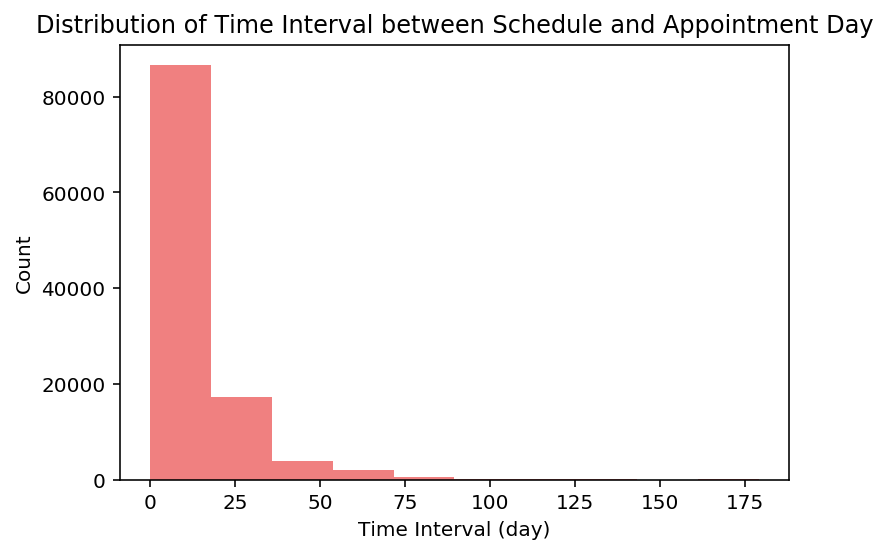

In [75]:
plt.hist(df['Time_interval'], color = 'lightcoral')
plt.title('Distribution of Time Interval between Schedule and Appointment Day')
plt.xlabel('Time Interval (day)')
plt.ylabel('Count');

由于`Time_interval`为数值变量，我们可以直接将其视作自变量建立逻辑回归模型，以探究时间间隔对未如约就诊概率的影响。

In [76]:
sm.Logit(df['No-show'], sm.add_constant(df['Time_interval'])).fit().summary()

Optimization terminated successfully.
         Current function value: 296.687735
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                No-show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110519
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:                -0.05941
Time:                        09:27:36   Log-Likelihood:            -3.2790e+07
converged:                       True   LL-Null:                   -3.0951e+07
                                        LLR p-value:                     1.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.6779      0.010   -175.079      0.000      -1.697      -1.659
Time_interval     0.0259      0.000     57.537      0.000       0.025       0.027
=================================================================================
"""

In [77]:
np.exp(0.0259)

1.0262383195101286

在逻辑回归的结果中，`Time_interval`的p值为`0.025`，小于我们设定的α水平0.05，因此`Time_interval`在很大的概率上对未如约就诊的概率有影响。

其系数为`0.0259`，说明时间间隔每增加一天，未如约就诊的概率就为原概率的`1.0262`倍。

然而，和患者的年龄因素一样，即使我们在这里得到了具有统计显著性的结果，我们也无法100%确认间隔时间会影响患者是否如约就诊的概率。这是因为回归模型的前提假设是“其它因素不变”，但是如果患者的从预约到就诊的间隔很长，很这可能暗示了患者需要进行就诊的疾病并不严重，所以如约就诊的概率也不是那么高。

也就是说，我们不能在增加时间间隔的同时，完全控制其它因素保持不变。

因此，我们无法完全肯定“`Time_interval`的增加会降低如约就诊的概率”这一结论。

<a id='conclusions'></a>
## 结论

在此次数据分析过程中，我们对数据集里110521条患者预约就诊信息与因变量（未如约就诊的概率）之间的关系进行了探究，得出的结论如下。

- 患者的性别对未能如约就诊的概率不存在影响。
- 患者所处年龄段这一自变量在很大的概率上对未能如约就诊的概率有影响，具体来说青年患者未能如约就诊的概率最大，老年患者未能如约就诊的概率最小。
- 有福利保障的患者的未能如约就诊概率高于无福利保障的患者。
- 酗酒对未如约就诊的概率没有影响，糖尿病和高血压均会降低患者未如约就诊的概率。
- 由于所有身上有两处及以上残疾的患者只有199位，仅为总体患者数量的0.0018左右，我们无法证明患者身上的残疾数量对未如约就诊的概率存在影响。
- 收到短信的患者未如约就诊的概率比未收到短信的患者要更高，这一结论方向和预期相反，由于缺乏对这一数据集的进一步解释信息，我们无法判断和短信提示关联的影响因素是什么。
- 患者预约到就诊的时间间隔越长，患者未如约就诊的概率也越高。

此次探究的主要局限性在于，即使对于某些因素我们得到了具有统计显著性的结果，我们也无法完全确定这一自变量会导致未如约就诊概率的增长或降低，因为在现实世界中，改变某一自变量的同时控制其它所有因素不变是一件几乎不可能的事情。

<a id='resources'></a>
## 参考网站

Hoppen, Joni. "Medical Appointment No Shows Dataset." Kaggle. August 20, 2017. Accessed March 14, 2018. https://www.kaggle.com/joniarroba/noshowappointments.

"Bolsa Família." Wikipedia. March 9, 2018. Accessed March 14, 2018. https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia.

"Multicollinearity." Wikipedia. March 08, 2018. Accessed March 14, 2018. https://en.wikipedia.org/wiki/Multicollinearity.

Barhum, Lana. "Diabetes and hypertension: What is the relationship?" Medical News Today. April 29, 2017. Accessed March 14, 2018. https://www.medicalnewstoday.com/articles/317220.php.